# COMP0036 Beat the Bookie Coursework - Group J (2021-22)


# Section 1 – Introduction

This Notebook supplements the PDF Report submitted for Group J's COMP0036 Coursework (2021-22).

Our code for predicting the results for the English Premier League (EPL) matches on 15 January 2022 is provided below.

Please note this Notebook has been tested using Python 3.8.

## 1.1 – Importing libraries

Below are all the libraries used over the course of the project.

In [1]:
from datetime import datetime
from math import exp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import (
    balanced_accuracy_score,
    brier_score_loss,
    confusion_matrix,
    f1_score,
    hamming_loss,
    jaccard_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.utils import multiclass
from xgboost import XGBRegressor

# Section 2 - Data Import

## 2.1 – Scraping

We scraped various additional datasets from websites to augment the provided training dataset. These include passing, possession & attendance data (per-match), player data (per-match), 2021-22 season data, and player market values.

An example of a scraper we wrote in Python for the passing, possession & attendance data is below:

```python
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

"""
This particuar version of the scraper is for the 2021-2022 season
The bulk of the code remains the same
Changes for each season are:
    The URL for the season's webpage
    The table ID for the season's webpage

Replace the path and season in df.to_csv (the last line) to save the dataframe as a CSV
"""

def get_data(url: str) -> dict:

    # Setup for BeautifulSoup for the individual match pages
    url = 'https://fbref.com' + url
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # Create the dictionary for one row of scraped data
    row = {
        'Date': None,
        'HomeTeam': None,
        'AwayTeam': None,
        'HomePossession': None,
        'AwayPossession': None,
        'HomePassTot' : None,
        'HomePassSucc' : None,
        'HomePassAcc' : None,
        'AwayPassTot' : None,
        'AwayPassSucc' : None,
        'AwayPassAcc' : None,
        'Attendance': None
    }

    # Get the date of the match
    date_t = soup.find('h1').text
    date_t = " ".join(date_t.split()[-3:])
    date_t = datetime.strptime(date_t, '%B %d, %Y')
    row['Date'] = date_t.strftime('%d/%m/%Y')

    # Find the div where a lot of the data required is stored
    team_stats = soup.find('div', id="team_stats")

    # Get the names of the teams
    teams = team_stats.findAll('span')
    row['HomeTeam'] = teams[0].text.strip()
    row['AwayTeam'] = teams[1].text.strip()

    # Get the possession for each team
    possession = team_stats.findAll('tr')[2].findAll('div')
    row['HomePossession'] = int(possession[1].text.strip()[:-1])
    row['AwayPossession'] = int(possession[5].text.strip()[:-1])

    # Get the home team's passing stats
    passing_accuracy = team_stats.findAll('tr')[4].findAll('div')[1].text.split()
    row['HomePassTot'] = int(passing_accuracy[2])
    row['HomePassSucc'] = int(passing_accuracy[0])
    row['HomePassAcc'] = round(row['HomePassSucc'] / row['HomePassTot'] * 100)

    # Get the away team's passing stats
    passing_accuracy = team_stats.findAll('tr')[4].findAll('div')[6].text.split()
    row['AwayPassTot'] = int(passing_accuracy[4])
    row['AwayPassSucc'] = int(passing_accuracy[2])
    row['AwayPassAcc'] = round(row['AwayPassSucc'] / row['AwayPassTot'] * 100)

    # Get the attendace for the match
    # Attendace was not recorded as time went back, and was affected by COVID-19
    # The try, except handles this well such that the code can handle these situations
    try:
        attendance = soup.find('div', id="content").findAll('div')[1].findAll('div')[25].text.split()[1]
        row['Attendance'] = int(attendance.replace(",", ""))
    except:
        row['Attendance'] = None

    return row

list_df = []

# Setup for BeautifulSoup for each season's webpage
url = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Find the correct table (the id changed for each season's table)
web_table = soup.find('table', id="sched_11160_1").findAll('tr')

# Scrape each match's data in that table by following the link to that match
for i in range(1, len(web_table)):
    # Some rows in the table are breaks between days
    # The try, except will skip these rows as there's no information to be scraped
    try:
        # Get the link and scrape the data
        data = get_data(web_table[i].findAll('a')[-1].get('href'))
        list_df.append(data)

        # Sleep is added so there aren't too many requests in a short time span
        time.sleep(0.5)
    except:
        # Move to next row if the current one doesn't hold a link to a match
        continue

# Form the dataframe from the list of dicts
df = pd.DataFrame(list_df)
print(df)
df.to_csv('<PATH_TO_LOCATION><SEASON>.csv', index=False)
```

## 2.2 – Merging

All the scraped data was then merged into one file using this script:

```python
from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd

# Team name mappings
mapping = {
    "AFC Bournemouth": "Bournemouth",
    "Blackburn Rovers": "Blackburn",
    "Bolton Wanderers": "Bolton",
    "Brighton & Hove Albion": "Brighton",
    "Cardiff City": "Cardiff",
    "Huddersfield Town": "Huddersfield",
    "Hull City": "Hull",
    "Leeds United": "Leeds",
    "Leicester City": "Leicester",
    "Manchester City": "Man City",
    "Manchester United": "Man United",
    "Manchester Utd": "Man United",
    "Newcastle United": "Newcastle",
    "Newcastle Utd": "Newcastle",
    "Norwich City": "Norwich",
    "Queens Park Rangers": "QPR",
    "Sheffield Utd": "Sheffield United",
    "Stoke City": "Stoke",
    "Swansea City": "Swansea",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wigan Athletic": "Wigan",
    "Wolverhampton Wanderers": "Wolves",
}


def map_names(name):
    return mapping[name] if name in mapping else name


# Custom date parser
def date_parser(x):
    for format in ["%d/%m/%Y", "%d/%m/%y", "%d %m %Y", "%d %B %Y"]:
        try:
            return datetime.strptime(x, format)
        except:
            continue
    raise ValueError(f"UGH {x}")


# Read the standard data
input_df = pd.read_csv(
    "epl-training.csv", parse_dates=["Date"], date_parser=date_parser
)

additional_2021_df = pd.read_csv(
    "2021-22 dariush format match stats.csv",
    parse_dates=["Date"],
    date_parser=date_parser,
)

additional_2021_df["HomeTeam"] = additional_2021_df["HomeTeam"].map(map_names)
additional_2021_df["AwayTeam"] = additional_2021_df["AwayTeam"].map(map_names)

input_df = input_df.append(additional_2021_df, sort=False)

print("Provided dataset - datatypes")
print(input_df.dtypes)

# Read Offensive Data
passing_possession_attendance_files = [
    "2014-2015.csv",
    "2015-2016.csv",
    "2016-2017.csv",
    "2017-2018.csv",
    "2018-2019.csv",
    "2019-2020.csv",
    "2020-2021.csv",
    "2021-2022.csv",
]

passing_possession_attendance_data = pd.concat(
    [
        pd.read_csv(
            f"Passing_Possession_Attendance/{file}",
            parse_dates=["Date"],
            date_parser=date_parser,
        )
        for file in passing_possession_attendance_files
    ],
    ignore_index=True,
)


passing_possession_attendance_data["HomeTeam"] = passing_possession_attendance_data[
    "HomeTeam"
].map(map_names)
passing_possession_attendance_data["AwayTeam"] = passing_possession_attendance_data[
    "AwayTeam"
].map(map_names)

print("Passing possession attendance data - datatypes")
print(passing_possession_attendance_data.dtypes)

# Read Player Data
match_players_files = [
    "2008-09.csv",
    "2009-10.csv",
    "2010-11.csv",
    "2011-12.csv",
    "2012-13.csv",
    "2013-14.csv",
    "2014-15.csv",
    "2015-16.csv",
    "2016-17.csv",
    "2017-18.csv",
    "2018-19.csv",
    "2019-20.csv",
    "2020-21.csv",
    "2021-22.csv",
]

match_players_dfs = []
for file in match_players_files:
    match_players_dfs.append(
        pd.read_csv(
            f"Per_Match_Per_Player/{file}",
            parse_dates=["Date"],
            date_parser=date_parser,
            skiprows=1,
            usecols=lambda x: x
            in [
                "Date",
                "Team",
                "Player",
                "Age",
                "Min",
                "Gls",
                "Ast",
                "PK",
                "Sh",
                "SoT",
                "CrdY",
                "CrdR",
                "Fls",
                "Fld",
                "Off",
                "Crs",
                "TklW",
                "Int",
                "OG",
            ],
        )
    )

    match_players_dfs[-1]["Season"] = file.rstrip(".csv")

match_players_df = pd.concat(match_players_dfs, ignore_index=True)

match_players_df["Age"] = match_players_df["Age"].map(lambda x: int(x.split("-")[0]))

match_players_df["Team"] = match_players_df["Team"].map(map_names)

noskipnasum = partial(pd.Series.sum, skipna=False)
noskipnamean = partial(pd.Series.mean, skipna=False)

# removed due to duplication: "shots_on_target", "yellow_cards", "red_cards","fouls",

aggregated_player_df = match_players_df.groupby(["Date", "Team", "Season"]).agg(
    mean_age=("Age", noskipnamean),
    mean_minutes_played=("Min", noskipnamean),
    goals=("Gls", noskipnasum),
    assists=("Ast", noskipnasum),
    penalty_kicks=("PK", noskipnasum),
    shots=("Sh", noskipnasum),
    # shots_on_target=('SoT', noskipnasum),
    # yellow_cards=('CrdY', 'sum'),
    # red_cards=('CrdR', 'sum'),
    # fouls=('Fls', noskipnasum),
    fouls_drawn=("Fld", noskipnasum),
    offsides=("Off", noskipnasum),
    crosses=("Crs", noskipnasum),
    winning_tackles=("TklW", noskipnasum),
    interceptions=("Int", noskipnasum),
    own_goals=("OG", noskipnasum),
)

# Read Market Value data

def parse_currency(x: str):
    multiplier = 1
    if "K" in x:
        multiplier = 10e3

    if "M" in x:
        multiplier = 10e6

    return float(x.lstrip("€").rstrip("K").strip("M")) * multiplier


player_value_files = [
    "2012-13.csv",
    "2013-14.csv",
    "2014-15.csv",
    "2015-16.csv",
    "2016-17.csv",
    "2017-18.csv",
    "2018-19.csv",
    "2019-20.csv",
    "2020-21.csv",
    "2021-22.csv",
]

player_value_dfs = []
for file in player_value_files:
    player_value_dfs.append(pd.read_csv(f"Player_Values/{file}"))
    player_value_dfs[-1]["Season"] = file.rstrip(".csv")

player_value_df = pd.concat(player_value_dfs, ignore_index=True)

player_value_df["Team"] = player_value_df["Club"].map(map_names)
player_value_df["Value"] = player_value_df["Value"].map(parse_currency)
player_value_df["Wage"] = player_value_df["Wage"].map(parse_currency)

print("Player values - datatypes")
print(player_value_df.dtypes)

agg_player_value_df = player_value_df.groupby(["Team", "Season"]).agg(
    mean_player_value=("Value", noskipnamean),
    mean_player_wage=("Wage", noskipnamean),
)

agg_player_value_df.to_csv("aggregated-player-values-by-season-1.csv")

aggregated_player_df = (
    aggregated_player_df.reset_index()
    .merge(agg_player_value_df.reset_index(), how="left", on=["Team", "Season"])
    .set_index(["Date", "Team"])
    .drop(columns=["Season"])
)

print("NEW AGGREGATED PLAYER DATATYPES")
print(aggregated_player_df.dtypes)


# Merge everything
merged_df = pd.merge(
    input_df[
        [
            "Date",
            "HomeTeam",
            "AwayTeam",
            "FTHG",
            "FTAG",
            "FTR",
            "HTHG",
            "HTAG",
            "HTR",
            "Referee",
            "HS",
            "AS",
            "HST",
            "AST",
            "HF",
            "AF",
            "HC",
            "AC",
            "HY",
            "AY",
            "HR",
            "AR",
        ]
    ].rename(
        columns={
            "FTHG": "h_fulltime_goals",
            "FTAG": "a_fulltime_goals",
            "FTR": "fulltime_result",
            "HTHG": "h_halftime_goals",
            "HTAG": "a_halftime_goals",
            "HTR": "halftime_result",
            "Referee": "referee",
            "HS": "h_shots_on_goal",
            "AS": "a_shots_on_goal",
            "HST": "h_shots_on_target",
            "AST": "a_shots_on_target",
            "HF": "h_fouls",
            "AF": "a_fouls",
            "HC": "h_corners",
            "AC": "a_corners",
            "HY": "h_yellow_cards",
            "AY": "a_yellow_cards",
            "HR": "h_red_cards",
            "AR": "a_red_cards",
        }
    ),
    passing_possession_attendance_data.rename(
        columns={
            "HomePossession": "h_possession",
            "AwayPossession": "a_possession",
            "HomePassTot": "h_total_passes",
            "HomePassSucc": "h_successful_passes",
            "HomePassAcc": "h_pass_accuracy",
            "AwayPassTot": "a_total_passes",
            "AwayPassSucc": "a_successful_passes",
            "AwayPassAcc": "a_pass_accuracy",
            "Attendance": "attendance",
        }
    ),
    how="left",
    on=["Date", "HomeTeam", "AwayTeam"],
)

merged_df = pd.merge(
    merged_df,
    aggregated_player_df.add_prefix("h_"),
    how="left",
    left_on=["Date", "HomeTeam"],
    right_on=["Date", "Team"],
)

merged_df = pd.merge(
    merged_df,
    aggregated_player_df.add_prefix("a_"),
    how="left",
    left_on=["Date", "AwayTeam"],
    right_on=["Date", "Team"],
)

merged_df.dropna(subset=["Date", "HomeTeam", "AwayTeam"], inplace=True)

merged_df.loc[:, ~merged_df.columns.str.contains("^Unnamed")].to_csv("training-11.csv")

print(merged_df)

print(merged_df.columns)

print(merged_df.dtypes)

```


## 2.3 – Import the merged dataset

`IterativeImputer` imputes the missing values by modelling each feature with missing values as a function of other features, given that the values are numeric.

In [2]:
print("IMPORTING DATA")
input_df = pd.read_csv("training-11.csv")

#########################
# IMPUTE MISSING VALUES #
#########################

non_numeric_columns = [
    "Date",
    "HomeTeam",
    "AwayTeam",
    "fulltime_result",
    "halftime_result",
    "referee",
]

numeric_columns = [
    col
    for col in input_df.columns
    if col not in non_numeric_columns and "Unnamed" not in col
]

print("IMPUTING MISSING VALUES")
imputer = IterativeImputer(max_iter=200, random_state=0).fit(
    input_df.loc[:, numeric_columns]
)
input_df[numeric_columns] = imputer.transform(input_df.loc[:, numeric_columns])

input_df.to_csv("training-11-imputed-1.csv")

IMPORTING DATA
IMPUTING MISSING VALUES


# Section 3 – Data Transformation & Exploration


## 3.1 – Feature Engineering

Create additional features by breaking up or combining existing features.

* Split the fulltime result into home and away outcomes 

In [3]:
input_df["h_outcome"] = input_df["fulltime_result"].apply(
    lambda x: {"H": 1, "A": -1, "D": 0}[x]
)
input_df["a_outcome"] = input_df["fulltime_result"].apply(
    lambda x: {"H": -1, "A": 1, "D": 0}[x]
)

* Calculate how many of the shots on goal were on target

In [4]:
input_df["h_shots_on_target_proportion"] = (
    input_df["h_shots_on_target"] / input_df["h_shots_on_goal"]
)

input_df["a_shots_on_target_proportion"] = (
    input_df["a_shots_on_target"] / input_df["a_shots_on_goal"]
)

* Combine the pressing actions

In [5]:
input_df["h_pressing_actions"] = (
    input_df["h_interceptions"] + input_df["h_winning_tackles"]
)

input_df["a_pressing_actions"] = (
    input_df["a_interceptions"] + input_df["a_winning_tackles"]
)

* Calculate how many of the opposing team's passes were intercepted

In [6]:
input_df["h_interceptions_per_opp_pass"] = (
    input_df["h_interceptions"] / input_df["a_total_passes"]
)

input_df["a_interceptions_per_opp_pass"] = (
    input_df["a_interceptions"] / input_df["h_total_passes"]
)

* Replace infinities and NANs with zeros

In [7]:
input_df.replace([np.inf, -np.inf, np.NINF, np.nan], 0, inplace=True)

## 3.2 – Preparing the training set

* Exclude columns which are irrelevant, such as the date or columns which can be inferred from others, such as a_possession (which is equal to 1 - h_possession)

In [8]:
excluded_columns = [
    "Date",
    "HomeTeam",
    "AwayTeam",
    "referee",
    "h_outcome",
    "a_outcome",
    "h_halftime_goals",
    "a_halftime_goals",
    "halftime_result",
    "a_possession",
    "h_goals",
    "a_goals",
]

* Rename the home team as "tm" (team) and the away team as "op" (opposition)

In [9]:
selected_columns = [
    ("#" + col)
    .replace("#h_", "tm_")
    .replace("#a_", "op_")
    .replace("#", "")
    for col in input_df.columns
    if col not in excluded_columns
    and "Unnamed" not in col
    and not col.startswith("ah_")
]
selected_columns

['tm_fulltime_goals',
 'op_fulltime_goals',
 'fulltime_result',
 'tm_shots_on_goal',
 'op_shots_on_goal',
 'tm_shots_on_target',
 'op_shots_on_target',
 'tm_fouls',
 'op_fouls',
 'tm_corners',
 'op_corners',
 'tm_yellow_cards',
 'op_yellow_cards',
 'tm_red_cards',
 'op_red_cards',
 'tm_possession',
 'tm_total_passes',
 'tm_successful_passes',
 'tm_pass_accuracy',
 'op_total_passes',
 'op_successful_passes',
 'op_pass_accuracy',
 'attendance',
 'tm_mean_age',
 'tm_mean_minutes_played',
 'tm_assists',
 'tm_penalty_kicks',
 'tm_shots',
 'tm_fouls_drawn',
 'tm_offsides',
 'tm_crosses',
 'tm_winning_tackles',
 'tm_interceptions',
 'tm_own_goals',
 'tm_mean_player_value',
 'tm_mean_player_wage',
 'op_mean_age',
 'op_mean_minutes_played',
 'op_assists',
 'op_penalty_kicks',
 'op_shots',
 'op_fouls_drawn',
 'op_offsides',
 'op_crosses',
 'op_winning_tackles',
 'op_interceptions',
 'op_own_goals',
 'op_mean_player_value',
 'op_mean_player_wage',
 'tm_shots_on_target_proportion',
 'op_shots_on_t

* Rename the columns for the dataframe

In [10]:
columns = ["is_home", "date", "team", "outcome"] + [
    col.replace("tm_", "")
    .replace("op_", "opp_")
    for col in selected_columns
]

* Arrange the columns so that home and away statistics are merged together and convert renamed columns back to their original names

In [11]:
cols = [
    ["Date", "HomeTeam", "h_outcome"]
    + [
        col.replace("tm_", "h_")
        .replace("op_", "a_")
        for col in selected_columns
    ],
    ["Date", "AwayTeam", "a_outcome"]
    + [
        col.replace("tm_", "a_")
        .replace("op_", "h_")
        for col in selected_columns
    ],
]

* Build the training dataset based on the columns generated above and store it in a dataframe

In [12]:
train_df = pd.DataFrame(
    [
        [1 if team == 0 else 0] + [row[cols[team][i]] for i in range(len(columns) - 1)]
        for _, row in input_df.iterrows()
        for team in range(2)
    ],
    columns=columns,
)

## 3.3 - Feature Selection

### 3.3.1 – Creating a correlation matrix

* Create a correlation matrix to determine which features significantly impact each other, in order to select the most relevant features

In [13]:
def generate_correlation_matrix(df):
    print("GENERATING CORRELATION MATRIX")

    sns.set(font_scale=0.8)

    corr = df.corr()
    plt.subplots(figsize=(48, 30), dpi=150)
    sns.heatmap(
        corr,
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values,
        cmap=sns.color_palette("mako", as_cmap=True),
        annot=True,
        fmt=".2g",
    )

    plt.tight_layout()

In [14]:
generate_correlation_matrix(train_df)

GENERATING CORRELATION MATRIX


### 3.3.2 – Excluding features

There are four models trained from the dataset: a model which predicts the expected goals won (`xG-won`), a model which predicts the goals conceded (`xG-con`), a model which predicts the expected defensive statistics (`xDef`) and a model which predicts the offensive statistics (`xOff`). 

When preparing the dataset for each model, we want to exclude irrelevant fatures, features which we want to predict, or features which will give the predictive algorithm an unfair advantage. Features which must be excluded from all datasets, such as:

* the date, which is irrelevant
* `fulltime_result` which we want to predict

Are included in `excluded_columns`. Other features are excluded based on what each model is trying to achieve, such as:

* The `fulltime_goals` which we want to predict in the `xG-won` model
* The number of `interceptions` in the defensive model

In [15]:
excluded_columns = {
    "fulltime_result",
    "halftime_result",
    "team",
    "date",
}

In [16]:
extra_xG_excluded_columns = {
    "fulltime_goals",
    "opp_fulltime_goals",
}

In [17]:
extra_xDef_excluded_columns = {
    "interceptions_per_opp_pass",
    "opp_interceptions_per_opp_pass",
    "interceptions",
    "opp_interceptions",
    "total_passes",
    "opp_total_passes",
    "successful_passes",
    "opp_successful_passes",
    "unsuccessful_passes",
    "opp_unsuccessful_passes"
}

In [18]:
extra_xOff_excluded_columns = {
    "shots_on_target_proportion",
    "opp_shots_on_target_proportion",
}

## 3.4 - Data Formatting

The function `preprocess_data`:
* Removes the excluded columns and shuffles the dataset to maintain a degree of randomness while training
* Scales the data
* Provides the option to perform Principal Component Analysis (PCA) to reduce the dimensionality of the dataset

In [19]:
def preprocess_data(
    df, columns, excluded_columns, y_column, y2_column=None, pca_components=None
):
    print(
        f"== PREPROCSESING DATA TO PREDICT {y_column}{f' & {y2_column}' if y2_column else ''} =="
    )

    # remove excluded columns
    X_not_shuffled = df.loc[:, list(set(columns) - excluded_columns)]

    # shuffle the training dataset
    pruned_df = df[df[y_column].notna()]
    shuffled_df = pruned_df.reindex(np.random.permutation(pruned_df.index))
    X_shuffled = shuffled_df.loc[:, list(set(columns) - excluded_columns)]
    y_shuffled = shuffled_df.loc[:, [y_column]]
    y2_shuffled = shuffled_df.loc[:, [y2_column]] if y2_column else None

    # scale the data
    print("SCALING THE DATA")
    scaler = preprocessing.StandardScaler().fit(
        X_shuffled
    )  # StandardScaler / MinMaxScaler 
    X_shuffled = scaler.transform(X_shuffled)
    X_not_shuffled = scaler.transform(X_not_shuffled)

    # PCA
    if pca_components:
        print("PERFORMING PCA")
        pca = PCA(n_components=pca_components).fit(X_shuffled)
        X_shuffled = pca.transform(X_shuffled)
        X_not_shuffled = pca.transform(X_not_shuffled)

    print(f"== PREPROCSESING COMPLETED ==")

    return X_not_shuffled, X_shuffled, y_shuffled, y2_shuffled

Pre-process the data individually for the expected goals models, defence model and offensive model, by excluding the corresponding features defined in 3.3

In [20]:
# Pre-process for xG model

(
    X_goals_not_shuffled,
    X_goals_shuffled,
    y_won_shuffled,
    y_conceded_shuffled,
) = preprocess_data(
    train_df,
    columns,
    excluded_columns | extra_xG_excluded_columns,
    "fulltime_goals",
    "opp_fulltime_goals",
)

== PREPROCSESING DATA TO PREDICT fulltime_goals & opp_fulltime_goals ==
SCALING THE DATA
== PREPROCSESING COMPLETED ==


In [21]:
# Pre-process for defence model

X_def_not_shuffled, X_def_shuffled, y_def_shuffled, _ = preprocess_data(
    train_df,
    columns,
    excluded_columns | extra_xDef_excluded_columns,
    "interceptions_per_opp_pass",
)

== PREPROCSESING DATA TO PREDICT interceptions_per_opp_pass ==
SCALING THE DATA
== PREPROCSESING COMPLETED ==


In [22]:
# Pre-process for offence model

X_off_not_shuffled, X_off_shuffled, y_off_shuffled, _ = preprocess_data(
    train_df,
    columns,
    excluded_columns | extra_xOff_excluded_columns,
    "shots_on_target_proportion",
)

== PREPROCSESING DATA TO PREDICT shots_on_target_proportion ==
SCALING THE DATA
== PREPROCSESING COMPLETED ==


# Section 4 – Methodology

The team’s methodology can be broken down into two main types of machine learning. Firstly, 4 models generate 4 values per team per match which define how they are expected to play. After this, these features are transformed into pre-match Elo ratings, detailing how successful they are in each of the four factors.

Finally, a classification model is trained on these Elo ratings, to predict the outcome of a given fixture. 


## 4.1 – Create and Train the 'expected' models.

This code defines the four ‘expected’ models, which generate different metrics of a team’s success. Information about these metrics can be found in sections 4.1.1-4.1.4.

Note that the machine-learning algorithms used differ based on the factor that’s being calculated. This is because the Bayesian optimisation procedure (described in Section 5) deemed them to be the most suitable models for calculating that specific factor.

In [23]:
model_xG_won = LinearSVR(C=0.005, max_iter=10000, random_state=120)

model_xG_conceded = LinearSVR(C=0.005, max_iter=10000, random_state=120)

model_xDef = ElasticNet(
    alpha=2.1465456836275086e-05,
    l1_ratio=0.20910359841779852,
    max_iter=2000,
    random_state=120,
)

model_xOff = ElasticNet(
    alpha=0.0003383553135592942, l1_ratio=1.0, max_iter=2000, random_state=120
)

- Code to generate a line plot showing the relationship betweneen training score and cross-validation score.

- The shaded area around each graph represents the standard deviation of that datapoint.

In [24]:
def generate_plot(name, train_sizes, train_scores, test_scores, legend_location):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)
    plt.rc('axes', titlesize=20, labelsize=15)

    plt.title(f'Training Score vs Cross-validation score - {name}\n')
    plt.xlabel('Number of Samples')
    plt.ylabel('Score')

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc = legend_location, fontsize = 12)
    plt.show()

### 4.1.1 – Expected Goals (xG-won)
This model predicts the number of goals a team is likely to score.

In [25]:
regressor_xG_won = model_xG_won.fit(X_goals_shuffled, y_won_shuffled.values.ravel())

# Use the regressor to predict xG given the dataset
train_df["xG"] = regressor_xG_won.predict(X_goals_not_shuffled)

In [26]:
train_sizes, train_scores, test_scores = learning_curve(model_xG_won, 
                              X_goals_shuffled, 
                              y_won_shuffled.values.ravel(), 
                              cv=5)

generate_plot("xG-won", train_sizes, train_scores, test_scores, "lower right")


### 4.1.2 – Expected Goals Conceded (xG-con)
Predicts the number of goals a team is likely to concede.

In [27]:
# create the expected goals conceded regressor
regressor_xG_conceded = model_xG_conceded.fit(
    X_goals_shuffled, y_conceded_shuffled.values.ravel()
)

# Use the regressor to predict xG conceded given the dataset
train_df["xGC"] = regressor_xG_conceded.predict(X_goals_not_shuffled)

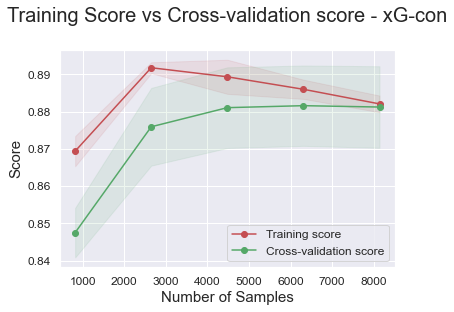

In [28]:
train_sizes, train_scores, test_scores = learning_curve(model_xG_conceded, 
                              X_goals_shuffled, 
                              y_conceded_shuffled.values.ravel(), 
                              cv=5)

generate_plot("xG-con", train_sizes, train_scores, test_scores, "lower right")

### 4.1.3 – Expected Defense (xDef)
Trained on defensive metrics such as interceptions and unsuccessful passes and serves to predict how well a team defends.

In [29]:
regressor_xDef = model_xDef.fit(X_def_shuffled, y_def_shuffled.values.ravel())

# Use the regressor to predict xG defensive given the dataset
train_df["xDef"] = regressor_xDef.predict(X_def_not_shuffled)

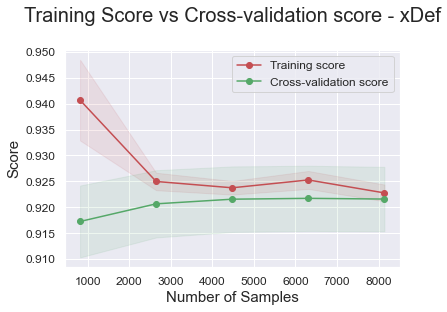

In [30]:
train_sizes, train_scores, test_scores = learning_curve(model_xDef, 
                              X_def_shuffled, 
                              y_def_shuffled.values.ravel(), 
                              cv=5)

generate_plot("xDef", train_sizes, train_scores, test_scores, "upper right")

### 4.1.4 – Expected Offence (xOff)
Likewise, this model predicts how well a team attacks based on metrics such as shots on target.

In [31]:
regressor_xOff = model_xOff.fit(X_off_shuffled, y_off_shuffled.values.ravel())

# Use the regressor to predict xG offencive given the dataset
train_df["xOff"] = regressor_xOff.predict(X_off_not_shuffled)

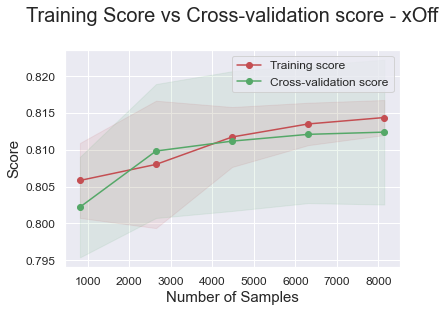

In [32]:
train_sizes, train_scores, test_scores = learning_curve(model_xOff, 
                              X_off_shuffled, 
                              y_off_shuffled.values.ravel(), 
                              cv=5)

generate_plot("xOff", train_sizes, train_scores, test_scores, "upper right")


## 4.2 – Calculate pre-match Elo rankings

* Elo starts from a set value and changes based on how different the actual result is from the expected value. 

* The amount of change is also multiplied by another factor, K, which determines the magnitude of the change. 


It was observed that matches played far in the past would have little to no impact on the current state of the game. Thus K becomes exponentially larger the closer a match was the the present, meaning more recent matches are much more impactful to the overall ELO.

In [33]:
now = datetime.now()

def ELO_K(date):
    delta = relativedelta(now, parse(date)).years
    return 100 * exp(-0.3 * delta)

def ELO_K_CONCEDED(date):
    delta = relativedelta(now, parse(date)).years
    return -50 * exp(-0.3 * delta)

def ELO_K_DEF(date):
    return 1000

def ELO_K_OFF(date):
    return 100

ELO_START = ELO_CONCEDED_START = 1000
ELO_DEF_START = ELO_OFF_START = 1000

ELO_FLOOR = ELO_CONCEDED_FLOOR = ELO_DEF_FLOOR = ELO_OFF_FLOOR = -np.inf

The function `calculate_elos`:

* Calculates Elos and Elo changes for a specific expected metric. It also splits the Elos into home and away Elos for use elsewhere. 

* Importantly, it calculates pre-match ELOs, as post-match Elos could not be used for a predictive classifier. 

In [34]:
def calculate_elos(df, elo_k, start, floor, column="fulltime_goals", expected="xG"):
    elos = {}
    home_elos = {}
    away_elos = {}

    prematch_elos = []
    prematch_home_elos = [start]
    prematch_away_elos = [start]
    postmatch_elos = []
    postmatch_home_elos = [start]
    postmatch_away_elos = [start]

    for _, row in df.iterrows():
        k = elo_k(row["date"])

        if row["team"] not in elos:
            elos[row["team"]] = [start]
            home_elos[row["team"]] = [start]
            away_elos[row["team"]] = [start]

        prematch_elos.append(elos[row["team"]][-1])

        if row["is_home"] == 1:
            prematch_home_elos.append(home_elos[row["team"]][-1])
            prematch_away_elos.append(prematch_away_elos[-1])
        else:
            prematch_home_elos.append(prematch_home_elos[-1])
            prematch_away_elos.append(away_elos[row["team"]][-1])

        diff = row[column] - row[expected]
        if not np.isfinite(diff):
            diff = 0

        elo = np.maximum(elos[row["team"]][-1] + k * diff, floor)

        elos[row["team"]].append(elo)
        postmatch_elos.append(elo)

        if row["is_home"] == 1:
            home_elo = np.maximum(home_elos[row["team"]][-1] + k * diff, floor)

            postmatch_home_elos.append(home_elo)
            postmatch_away_elos.append(postmatch_away_elos[-1])
            home_elos[row["team"]].append(home_elo)
        else:
            away_elo = np.maximum(away_elos[row["team"]][-1] + k * diff, floor)

            postmatch_home_elos.append(postmatch_home_elos[-1])
            postmatch_away_elos.append(away_elo)
            away_elos[row["team"]].append(away_elo)

    return (
        prematch_elos,
        prematch_home_elos[1:],
        prematch_away_elos[1:],
        elos,
        home_elos,
        away_elos,
    )

* Calculate an Elo ranking for each 'expected' model defined above.

In [35]:
# Elo Ranking of xG model

(
    train_df["prematch_elo"],
    train_df["prematch_home_elo"],
    train_df["prematch_away_elo"],
    final_elos,
    final_home_elos,
    final_away_elos,
) = calculate_elos(
    train_df,
    elo_k=ELO_K,
    start=ELO_START,
    floor=ELO_FLOOR,
    column="fulltime_goals",
    expected="xG",
)

In [36]:
# Elo Ranking of xG conceded model

(
    train_df["prematch_conceded_elo"],
    train_df["prematch_conceded_home_elo"],
    train_df["prematch_conceded_away_elo"],
    final_conceded_elos,
    final_conceded_home_elos,
    final_conceded_away_elos,
) = calculate_elos(
    train_df,
    elo_k=ELO_K_CONCEDED,
    start=ELO_CONCEDED_START,
    floor=ELO_CONCEDED_FLOOR,
    column="opp_fulltime_goals",
    expected="xGC",
)

In [37]:
# Elo Ranking of xG deffensive model

(
    train_df["prematch_def_elo"],
    train_df["prematch_def_home_elo"],
    train_df["prematch_def_away_elo"],
    final_def_elos,
    final_def_home_elos,
    final_def_away_elos,
) = calculate_elos(
    train_df,
    elo_k=ELO_K_DEF,
    start=ELO_DEF_START,
    floor=ELO_DEF_FLOOR,
    column="interceptions_per_opp_pass",
    expected="xDef",
)

In [38]:
# Elo Ranking of xG offensive model

(
    train_df["prematch_off_elo"],
    train_df["prematch_off_home_elo"],
    train_df["prematch_off_away_elo"],
    final_off_elos,
    final_off_home_elos,
    final_off_away_elos,
) = calculate_elos(
    train_df,
    elo_k=ELO_K_OFF,
    start=ELO_OFF_START,
    floor=ELO_OFF_FLOOR,
    column="shots_on_target_proportion",
    expected="xOff",
)

* Display the final Elo rankings

FINAL ELO RANKINGS (TOP 15):
Man City 4102 779 1361 1089
West Ham 2677 927 965 1076
Southampton 2541 519 902 1094
Crystal Palace 2513 -29 1170 922
Chelsea 2414 440 563 681
Tottenham 2376 336 1364 712
Liverpool 2206 909 668 923
Arsenal 1919 553 1023 755
Everton 1814 477 952 1085
Wolves 1761 818 969 1120
West Brom 1595 798 1055 726
Newcastle 1464 353 1275 1236
Sunderland 1420 882 1091 1454
Brighton 1416 779 905 969
Burnley 1412 991 1122 842


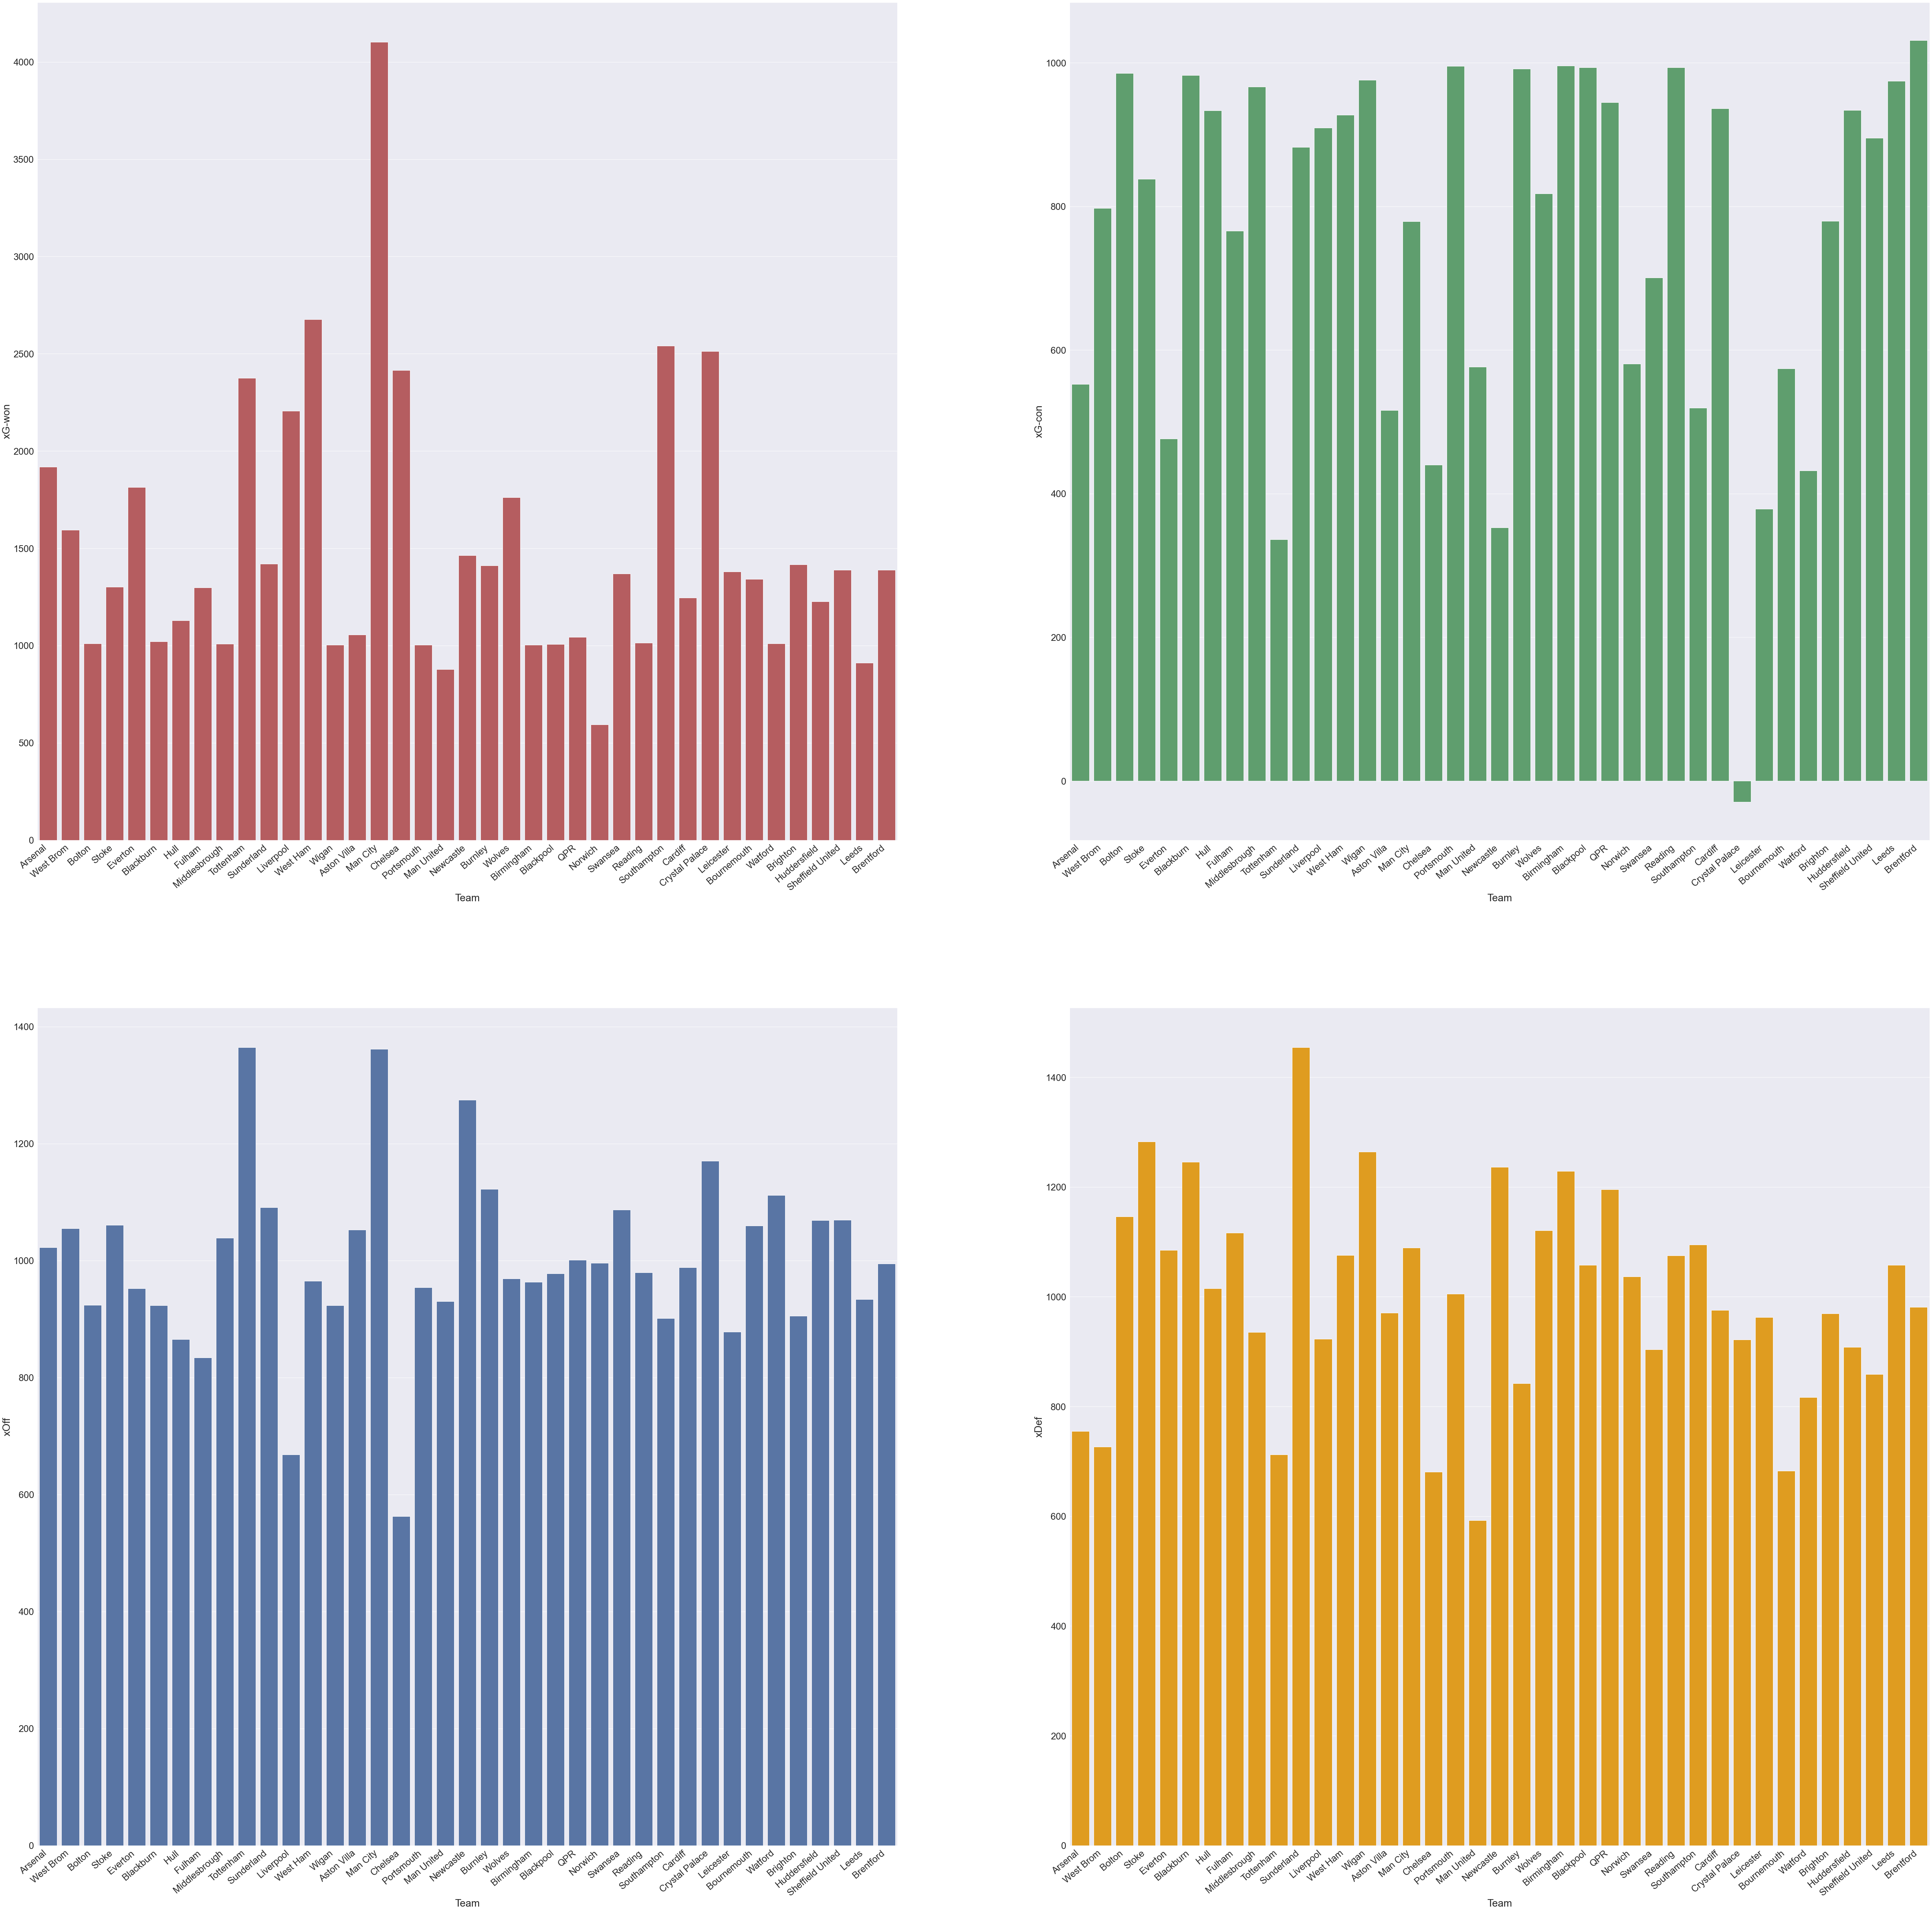

In [49]:
print("FINAL ELO RANKINGS (TOP 15):")
for k in sorted(final_elos.keys(), key=lambda x: (final_elos[x][-1]),)[
    ::-1
][:15]:
    print(
        k,
        round(final_elos[k][-1]),
        round(final_conceded_elos[k][-1]),
        round(final_def_elos[k][-1]),
        round(final_off_elos[k][-1]),
    )

# Plot Elo bar charts
sns.set(font_scale = 2.5)

presentation_df = pd.DataFrame({'Team': final_elos.keys(),
                                'xG-won': [final_elos[k][-1] for k in final_elos.keys()],
                                'xG-con': [final_conceded_elos[k][-1] for k in final_elos.keys()],
                                'xOff': [final_def_elos[k][-1] for k in final_elos.keys()],
                                'xDef': [final_off_elos[k][-1] for k in final_elos.keys()]})

fig, axes = plt.subplots(2, 2, figsize=(100,100))

try:
    sns.barplot(data=presentation_df, x='Team', y='xG-won', ax=axes[0,0], color='r').set_xticklabels(final_elos.keys(), rotation=40, ha="right")
    sns.barplot(data=presentation_df, x='Team', y='xG-con', ax=axes[0,1], color='g').set_xticklabels(final_elos.keys(), rotation=40, ha="right")
    sns.barplot(data=presentation_df, x='Team', y='xOff', ax=axes[1,0], color='b').set_xticklabels(final_elos.keys(), rotation=40, ha="right")
    sns.barplot(data=presentation_df, x='Team', y='xDef', ax=axes[1,1], color='orange').set_xticklabels(final_elos.keys(), rotation=40, ha="right");
except:
    pass

# Section 5 – Model Training and Validation

As previously stated, the classifier should ingest Elo values and output the result for the match. 
This code creates the model (`model_result`) and adds all the Elos to `match_elo_df`.

In [40]:
model_result = KNeighborsClassifier(n_jobs=1, n_neighbors=11, p=1.9044655262488992)
prematch_elos = []

it = iter(train_df.iterrows())
for home, away in zip(it, it):
    prematch_elos.append(
        [
            home[1]["date"],
            home[1]["team"],
            away[1]["team"],
            home[1]["prematch_elo"],
            home[1]["prematch_home_elo"],
            home[1]["prematch_away_elo"],
            away[1]["prematch_elo"],
            away[1]["prematch_home_elo"],
            away[1]["prematch_away_elo"],
            home[1]["prematch_conceded_elo"],
            home[1]["prematch_conceded_home_elo"],
            home[1]["prematch_conceded_away_elo"],
            away[1]["prematch_conceded_elo"],
            away[1]["prematch_conceded_home_elo"],
            away[1]["prematch_conceded_away_elo"],
            home[1]["prematch_def_elo"],
            home[1]["prematch_def_home_elo"],
            home[1]["prematch_def_away_elo"],
            away[1]["prematch_def_elo"],
            away[1]["prematch_def_home_elo"],
            away[1]["prematch_def_away_elo"],
            home[1]["prematch_off_elo"],
            home[1]["prematch_off_home_elo"],
            home[1]["prematch_off_away_elo"],
            away[1]["prematch_off_elo"],
            away[1]["prematch_off_home_elo"],
            away[1]["prematch_off_away_elo"],
            home[1]["fulltime_result"],
        ]
    )

match_elo_df = pd.DataFrame(
    prematch_elos,
    columns=[
        "date",
        "home_team",
        "away_team",
        "home_elo",
        "home_while_home_elo",
        "home_while_away_elo",
        "away_elo",
        "away_while_home_elo",
        "away_while_away_elo",
        "home_conceded_elo",
        "home_conceded_while_home_elo",
        "home_conceded_while_away_elo",
        "away_conceded_elo",
        "away_conceded_while_home_elo",
        "away_conceded_while_away_elo",
        "home_def_elo",
        "home_def_while_home_elo",
        "home_def_while_away_elo",
        "away_def_elo",
        "away_def_while_home_elo",
        "away_def_while_away_elo",
        "home_off_elo",
        "home_off_while_home_elo",
        "home_off_while_away_elo",
        "away_off_elo",
        "away_off_while_home_elo",
        "away_off_while_away_elo",
        "fulltime_result",
    ],
)

match_elo_df = match_elo_df.reindex(np.random.permutation(match_elo_df.index))

In [41]:
match_elo_columns = [
    "home_elo",
    # "home_while_home_elo",
    # "home_while_away_elo",
    "away_elo",
    # "away_while_home_elo",
    # "away_while_away_elo",
    "home_conceded_elo",
    # "home_conceded_while_home_elo",
    # "home_conceded_while_away_elo",
    "away_conceded_elo",
    # "away_conceded_while_home_elo",
    # "away_conceded_while_away_elo",
    "home_def_elo",
    # "home_def_while_home_elo",
    # "home_def_while_away_elo",
    "away_def_elo",
    # "away_def_while_home_elo",
    # "away_def_while_away_elo",
    "home_off_elo",
    # "home_off_while_home_elo",
    # "home_off_while_away_elo",
    "away_off_elo",
    # "away_off_while_home_elo",
    # "away_off_while_away_elo",
]

X_match_elo = match_elo_df.loc[:, match_elo_columns]
y_match_elo = match_elo_df.loc[:, ["fulltime_result"]]

* Standardise the data

In [42]:
standardiser = preprocessing.StandardScaler().fit(X_match_elo)
X_match_elo = standardiser.transform(X_match_elo)

* Create the match result classifier and perform k-folds validation
* Score the classifier using metrics from Scikit Learn

In [43]:
classifier = model_result.fit(X_match_elo, y_match_elo.values.ravel())
y_match_elo_true = y_match_elo.values.ravel()
y_match_elo_pred = classifier.predict(X_match_elo)

scores = cross_validate(
    classifier,
    X_match_elo,
    y_match_elo.values.ravel(),
    cv=5,
    n_jobs=12,
    scoring={
        "f1_macro": "f1_macro",
        "f1_micro": "f1_micro",
        "balanced_accuracy": "balanced_accuracy",
        "precision_macro": "precision_macro",
        "precision_micro": "precision_micro",
        "recall_macro": "recall_macro",
        "recall_micro": "recall_micro",
        "jaccard_macro": "jaccard_macro",
        "jaccard_micro": "jaccard_micro",
        "hamming_loss": make_scorer(hamming_loss),
    },
    return_train_score=True,
)

# Section 6 - Results

fit_time ===> mean: 0.024302339553833006 ; stddev: 0.003610284974968964 ; scores: [0.02567387 0.01726675 0.02761054 0.02566862 0.02529192]
score_time ===> mean: 0.9253681182861329 ; stddev: 0.014142615411885369 ; scores: [0.9335804  0.93111563 0.89871645 0.92434049 0.93908763]
test_f1_macro ===> mean: 0.4143103701003531 ; stddev: 0.0016532441205624735 ; scores: [0.41148803 0.4140332  0.41661381 0.41473009 0.41468672]
train_f1_macro ===> mean: 0.531825997940058 ; stddev: 0.009629523090634176 ; scores: [0.53952413 0.51719115 0.52770367 0.54484062 0.52987042]
test_f1_micro ===> mean: 0.47357129196585357 ; stddev: 0.0034030119782018134 ; scores: [0.4675835  0.47347741 0.47347741 0.47544204 0.47787611]
train_f1_micro ===> mean: 0.5791414934036762 ; stddev: 0.008549101897818592 ; scores: [0.58486858 0.56619995 0.57848195 0.59125522 0.57490177]
test_balanced_accuracy ===> mean: 0.4247388131205505 ; stddev: 0.001648039881538394 ; scores: [0.42394432 0.42378441 0.42587651 0.42274693 0.42734191]

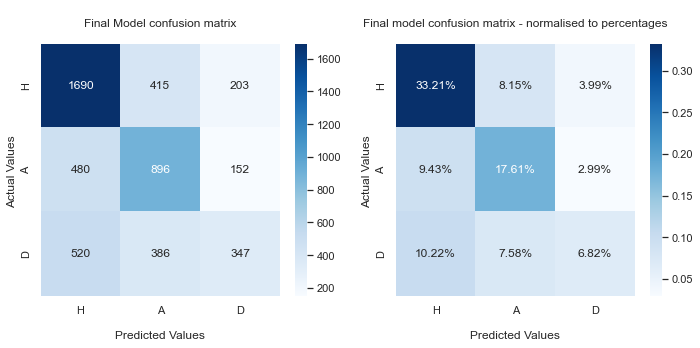


Hamming loss: 0.4236588720770289


In [44]:
for score in scores:
    print(
        score,
        "===>",
        "mean:",
        scores[score].mean(),
        "; stddev:",
        scores[score].std(),
        "; scores:",
        scores[score],
    )


try:

    sns.set()

    # Generate confusion matrix
    cm = confusion_matrix(y_match_elo_true, y_match_elo_pred, labels=["H", "A", "D"])

    # Plot confusion matrices
    plt.subplots(1,2, figsize=(10,5))
    plt.subplot(1,2,1)

    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

    ax.set_title('\nFinal Model confusion matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(["H", "A", "D"])
    ax.yaxis.set_ticklabels(["H", "A", "D"])
    

    # Display normalised confusion matrix
    plt.subplot(1,2,2)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

    ax.set_title('\nFinal model confusion matrix - normalised to percentages\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(["H", "A", "D"])
    ax.yaxis.set_ticklabels(["H", "A", "D"])

    plt.tight_layout()
    plt.show()

except:
    pass

try:
    print(
        "\nROC AUC score (macro, ovo):",
        roc_auc_score(
            y_match_elo_true, y_match_elo_pred, average="macro", multi_class="ovo"
        ),
    )
except:
    pass

try:
    print(
        "\nHamming loss:",
        hamming_loss(y_match_elo_true, y_match_elo_pred),
    )
except:
    pass


# Section 7 - Final Predictions on Test Set

* Define January's matches

In [45]:
january_matches = [
    ("Aston Villa", "Man United"),
    ("West Ham", "Leeds"),
    ("Norwich", "Everton"),
    ("Brighton", "Crystal Palace"),
    ("Wolves", "Southampton"),
    ("Liverpool", "Brentford"),
    ("Tottenham", "Arsenal"),
    ("Man City", "Chelsea"),
    ("Newcastle", "Watford"),
    ("Burnley", "Leicester"),
]

* Create the final dataframe to put into the classifier

  Note that home and away Elos were initially used in the prediction but were found to be detrimental to the F1-score. They have been left in as comments as an option to try this approach to the problem.

In [46]:
january_df = pd.DataFrame(
    [
        [
            home,
            away,
            final_elos.get(home, [ELO_START])[-1],
            # final_home_elos.get(home, [ELO_START])[-1],
            # final_away_elos.get(home, [ELO_START])[-1],
            final_elos.get(away, [ELO_START])[-1],
            # final_home_elos.get(away, [ELO_START])[-1],
            # final_away_elos.get(away, [ELO_START])[-1],
            final_conceded_elos.get(home, [ELO_START])[-1],
            # final_conceded_home_elos.get(home, [ELO_START])[-1],
            # final_conceded_away_elos.get(home, [ELO_START])[-1],
            final_conceded_elos.get(away, [ELO_START])[-1],
            # final_conceded_home_elos.get(away, [ELO_START])[-1],
            # final_conceded_away_elos.get(away, [ELO_START])[-1],
            final_def_elos.get(home, [ELO_START])[-1],
            # final_def_home_elos.get(home, [ELO_START])[-1],
            # final_def_away_elos.get(home, [ELO_START])[-1],
            final_def_elos.get(away, [ELO_START])[-1],
            # final_def_home_elos.get(away, [ELO_START])[-1],
            # final_def_away_elos.get(away, [ELO_START])[-1],
            final_off_elos.get(home, [ELO_START])[-1],
            # final_off_home_elos.get(home, [ELO_START])[-1],
            # final_off_away_elos.get(home, [ELO_START])[-1],
            final_off_elos.get(away, [ELO_START])[-1],
            # final_off_home_elos.get(away, [ELO_START])[-1],
            # final_off_away_elos.get(away, [ELO_START])[-1],
        ]
        for home, away in january_matches
    ],
    columns=["home_team", "away_team"] + match_elo_columns,
)

* Calculate January's predictions

In [47]:
january_df["result"] = classifier.predict(
    standardiser.transform(january_df.loc[:, match_elo_columns])
)

The final January predictions are:

In [48]:
print(
    january_df.loc[
        :,
        [
            "home_team",
            "away_team",
            "home_elo",
            "home_conceded_elo",
            "home_def_elo",
            "home_off_elo",
            "away_elo",
            "away_conceded_elo",
            "away_def_elo",
            "away_off_elo",
            "result",
        ],
    ]
)

     home_team       away_team     home_elo  home_conceded_elo  home_def_elo  \
0  Aston Villa      Man United  1055.776171         516.033210   1052.829688   
1     West Ham           Leeds  2676.633209         927.255234    964.927140   
2      Norwich         Everton   594.381604         580.695729    995.928441   
3     Brighton  Crystal Palace  1416.163402         779.462907    905.419732   
4       Wolves     Southampton  1761.415278         817.687528    969.205639   
5    Liverpool       Brentford  2205.998431         909.441929    668.403745   
6    Tottenham         Arsenal  2375.500843         336.316293   1364.212508   
7     Man City         Chelsea  4101.801145         779.104629   1361.365592   
8    Newcastle         Watford  1464.247870         352.882340   1274.881826   
9      Burnley       Leicester  1411.799417         991.324954   1122.340280   

   home_off_elo     away_elo  away_conceded_elo  away_def_elo  away_off_elo  \
0    970.277044   878.311521         576

# Section 8 – Model Selection and Hyperparameter Tuning

A Bayesian Optimisation technique was applied to discover the optimum algorithm for each of the group's machine learning models

## 8.1 – 'Expected' models

Here a wide variety of algorithms are systematically tested on the dataset to see what the most succeessful one is.

Originally, different types of models (e.g. linear, SVRs etc) were separated into their own individual files for ease of use, however they have been amalgamated for display purposes.

The final models that were selected were `linearSVR` for `xG-won` and `xG-con`, and `ElasticNet` for `xDef` and `xOff`.

More information about this can be found in section 4.1 of the team's final report.

* Imports and declaration of parameters, in this case the models being used.

```python
import warnings
from datetime import datetime
from math import exp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import (
    ElasticNet,
    Lasso,
    LogisticRegression,
    Ridge,
    SGDRegressor,
)
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVC, LinearSVR
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from xgboost import XGBRegressor

warnings.simplefilter("ignore", category=ConvergenceWarning)


##############
# PARAMETERS #
##############

pipe_regressor = Pipeline([("model", LinearSVR())])
pipe_classifier = Pipeline([("model", LinearSVC())])

n = 100

param_grid_regression = [
    (
        {
            "model": [LinearSVR(verbose=0, random_state=120, max_iter=2000)],
            "model__C": Real(1e-6, 1e3, prior="log-uniform"),
        },
        n,
    ),
    (
        {
            "model": [Ridge(random_state=120, max_iter=2000)],
            "model__alpha": Real(1e-3, 1e5, prior="log-uniform"),
        },
        n,
    ),
    (
        {
            "model": [Lasso(random_state=120, max_iter=2000)],
            "model__alpha": Real(1e-3, 1e5, prior="log-uniform"),
        },
        n,
    ),
    (
        {
            "model": [ElasticNet(random_state=120, max_iter=2000)],
            "model__alpha": Real(1e-6, 1e5, prior="log-uniform"),
            "model__l1_ratio": Real(1e-6, 1, prior="log-uniform"),
        },
        n,
    ),
    (
        {
            "model": [SGDRegressor(verbose=0, random_state=120, max_iter=2000)],
            "model__loss": Categorical(
                [
                    "squared_error",
                    "huber",
                    "epsilon_insensitive",
                    "squared_epsilon_insensitive",
                ]
            ),
            "model__penalty": Categorical(["l2", "none"]),
            "model__alpha": Real(1e-6, 1e5, prior="log-uniform"),
            "model__epsilon": Real(1e-6, 1e5, prior="log-uniform"),
            "model__learning_rate": Categorical(
                ["invscaling", "constant", "optimal", "adaptive"]
            ),
        },
        n,
    ),
    (
        {
            "model": [SVR(verbose=0, max_iter=2000)],
            "model__C": (1e-6, 1e3, "log-uniform"),
            "model__gamma": (1e-6, 1e1, "log-uniform"),
            "model__degree": (1, 8),
            "model__kernel": ["poly", "rbf"],
        },
        20,
    ),
    (
        {
            "model": [
                XGBRegressor(
                    random_state=120,
                    n_jobs=1,
                )
            ],
            "model__n_estimators": Integer(50, 1200),
            "model__max_depth": Integer(4, 10),
            "model__gamma": Real(1e-4, 1e2, prior="log-uniform"),
            # "model__learning_rate": Real(1e-4, 1e1, prior="log-uniform"), # this causes it to crash!
            "model__reg_alpha": Real(1e-4, 1e2, prior="log-uniform"),
            "model__reg_lambda": Real(1e-4, 1e2, prior="log-uniform"),
        },
        10,
    ),
        (
        {
            "model": [AdaBoostRegressor(random_state=120)],
            "model__n_estimators": (10, 5000),
            "model__learning_rate": (1e-2, 1e2, "log-uniform"),
        },
        10,
    ),
    (
        {
            "model": [KNeighborsRegressor(n_jobs=1)],
            "model__n_neighbors": (3, 41),
            "model__p": (1.0, 2.0, "uniform"),
        },
        10,
    ),
    (
        {
            "model": [RandomForestRegressor(verbose=0, random_state=120, n_jobs=1)],
            "model__n_estimators": (10, 5000),
            "model__bootstrap": [True, False],
            "model__max_depth": (10, 500),
            "model__max_features": ["auto", "sqrt", "log2"],
            "model__min_samples_split": (2, 10),
            "model__min_samples_leaf": (2, 10),
        },
        10,
    ),
]

fit_params = {"model__eval_metric": "r2"}

```



* `create_estimator` ingests a model and quantifies how good it performs on a dataseet

```python
def create_estimator(name, model, param_grid, X, y, scoring=None, fit_params=None):
    print(f"TRAINING {name} ESTIMATOR")

    # perform a grid search to find the best estimator
    # the best estimator is retrained on the full dataset
    estimator = BayesSearchCV(
        model,
        param_grid,
        refit=True,
        verbose=0,
        n_jobs=10,
        n_points=10,
        cv=5,
        scoring=scoring,
        fit_params=fit_params,
    )

    estimator.fit(X, y.values.ravel())

    print(f"BEST {name} ESTIMATOR:", estimator.best_estimator_)
    print(f"BEST {name} PARAMS:", estimator.best_params_)
    print(f"BEST {name} CROSS-VALIDATION SCORE:", estimator.best_score_)

    pd.DataFrame.from_dict(estimator.cv_results_).to_csv(
        f"Estimator_CV_Results/{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}-{name}.csv"
    )

    return estimator
```



* Remaining code to import data and run the function

```python
###################
# IMPORT THE DATA #
###################

print("IMPORTING DATA")
train_df = pd.read_csv("train_df-2.csv")
# missing values have already been imputed, features have already been engineered

train_df = train_df.loc[:, ~train_df.columns.str.contains("^Unnamed")]
train_df.replace([np.inf, -np.inf, np.NINF, np.nan], 0, inplace=True)
train_df.reset_index()

######################################
# TRAIN THE EXPECTED GOALS REGRESSOR #
######################################

print("STARTING AT", datetime.now())
regressor_xG = create_estimator(
    name="xG won",
    model=pipe_regressor,
    param_grid=param_grid_regression,
    X=X_goals_shuffled,
    y=y_won_shuffled,
    scoring="r2",
    fit_params=fit_params,
)

regressor_xGC = create_estimator(
    name="xG conceded",
    model=pipe_regressor,
    param_grid=param_grid_regression,
    X=X_goals_shuffled,
    y=y_conceded_shuffled,
)

# make the xG won and xG conceded predictions
train_df["xG"] = regressor_xG.predict(X_goals_not_shuffled)
train_df["xGC"] = regressor_xGC.predict(X_goals_not_shuffled)


regressor_xDef = create_estimator(
    name="xDef",
    model=pipe_regressor,
    param_grid=param_grid_regression,
    X=X_def_shuffled,
    y=y_def_shuffled,
    scoring="r2",
    fit_params=fit_params,
)

# predict the defensive metric
train_df["xDef"] = regressor_xDef.predict(X_def_not_shuffled)

regressor_xOff = create_estimator(
    name="xOff",
    model=pipe_regressor,
    param_grid=param_grid_regression,
    X=X_off_shuffled,
    y=y_off_shuffled,
    scoring="r2",
    fit_params=fit_params,
)
```



## 8.2 – Classifier

- Much of this code is similar to the team's final method of Elo ranking so only the unique parts are displayed for conciseness.
- Again, the classifier is trained using multiple different machine learning algorithms and the best one is selected. In this case being the `KNeighborsClassifier`

```python

pipe_classifier = Pipeline([("model", LinearSVC())])


param_grid_classification = [
    (
        {
            "model": [LinearSVC(verbose=0, max_iter=2000)],
            "model__C": (1e-6, 1e3, "log-uniform"),
        },
        5,
    ),
    (
        {
            "model": [KNeighborsClassifier(n_jobs=1)],
            "model__n_neighbors": Integer(3, 39),
            "model__p": Real(1.0, 2.0, prior="uniform"),
        },
        20,
    ),
]

fit_params = {"model__eval_metric": "f1_macro"}

# create the match result classifier
classifier = create_estimator(
    name="match result",
    model=pipe_classifier,
    param_grid=param_grid_classification,
    X=X_match_elo,
    y=y_match_elo,
    scoring="f1_macro",
    fit_params=fit_params,
)
```

